In [1]:
import sys
sys.path.append('..')
sys.path.append('../..')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.anova import AnovaRM  # perform F test

import selective_recruitment.globals as gl
import Functional_Fusion.dataset as ds 

from pathlib import Path

import warnings
warnings.filterwarnings('ignore')

In [2]:
behav_dir = 'A:\\data\\Cerebellum\\CerebellumWorkingMemory\\data\\fmri'
wkdir = 'A:\data\Cerebellum\CerebellumWorkingMemory\selective_recruit'

# behavioral performance inside scanner

In [13]:
# get the behavioral dataframe
df = pd.read_csv(behav_dir + "/df_wm.csv", sep = "\t")
D = df[["isErrorM", "isError", "numErrors", "MnumErrors", "NMnumErrors"]]
D["phase"] = df.exec
D["load"] = df.load
D["recall_dir"] = df.seqType
D["sn"] = df.sn
D["isCorrectM"] = 1 - D["isErrorM"]
D["isCorrectTot"] = 1 - D["isError"]
D["nonmemError"] = D["numErrors"] - D["MnumErrors"]
D["isErrorNM"] = (D["nonmemError"] > 0)*1
D["isCorrectNM"] = 1 - D["isErrorNM"]


# D["isCorrectM"].describe()

count    3360.000000
mean        0.911607
std         0.283908
min         0.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: isCorrectM, dtype: float64

                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load            15.3600 2.0000 30.0000 0.0000
recall_dir       5.4470 1.0000 15.0000 0.0339
load:recall_dir  0.5661 2.0000 30.0000 0.5737



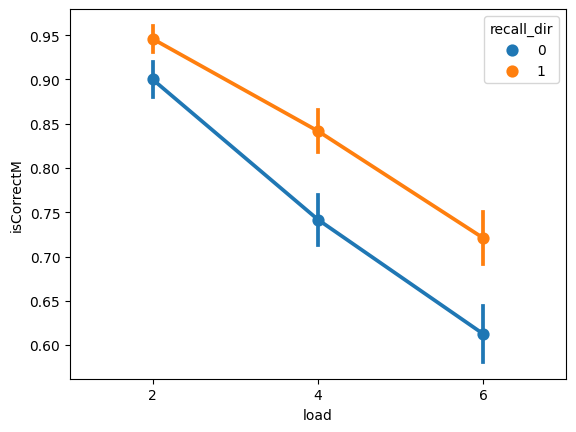

In [16]:
sns.pointplot(data = D.loc[D.phase == 1], x = "load", y =  "isCorrectM", hue = "recall_dir", errorbar="se")
plt.savefig("behaviour_percent_correct.pdf")
print(AnovaRM(data=D.loc[(D.phase == 1)], depvar='isCorrectM',subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())


                    Anova
                F Value Num DF  Den DF Pr > F
---------------------------------------------
load             9.4183 2.0000 30.0000 0.0007
recall_dir       8.8055 1.0000 15.0000 0.0096
load:recall_dir  0.0309 2.0000 30.0000 0.9696



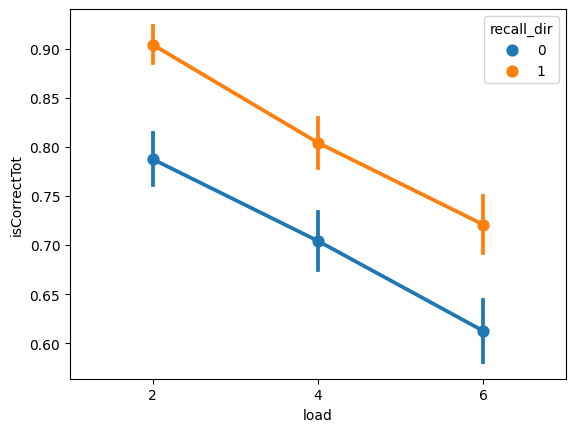

In [39]:
sns.pointplot(data = D.loc[D.phase == 1], x = "load", y =  "isCorrectTot", hue = "recall_dir", errorbar="se")
plt.savefig("behaviour_percent_correct.pdf")
print(AnovaRM(data=D.loc[D.phase == 1], depvar='isCorrectTot',subject='sn', within=['load', 'recall_dir'], aggregate_func=np.mean).fit())


# BOLD activation vs behavioral performance

In [21]:
# load data for the cerebellar parcellation
cereb1_df = pd.read_csv(Path(wkdir) / "NettekovenSym32_df.csv", index_col = 0)

# load data for the cerebellar parcellation
cereb2_df = pd.read_csv(Path(wkdir) / "NettekovenSym32integLRAP_df.csv", index_col = 0)

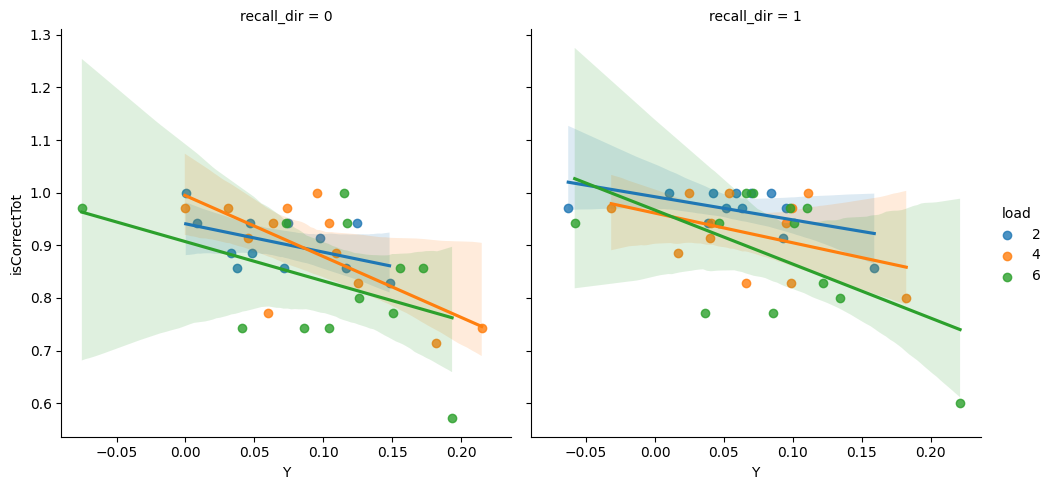

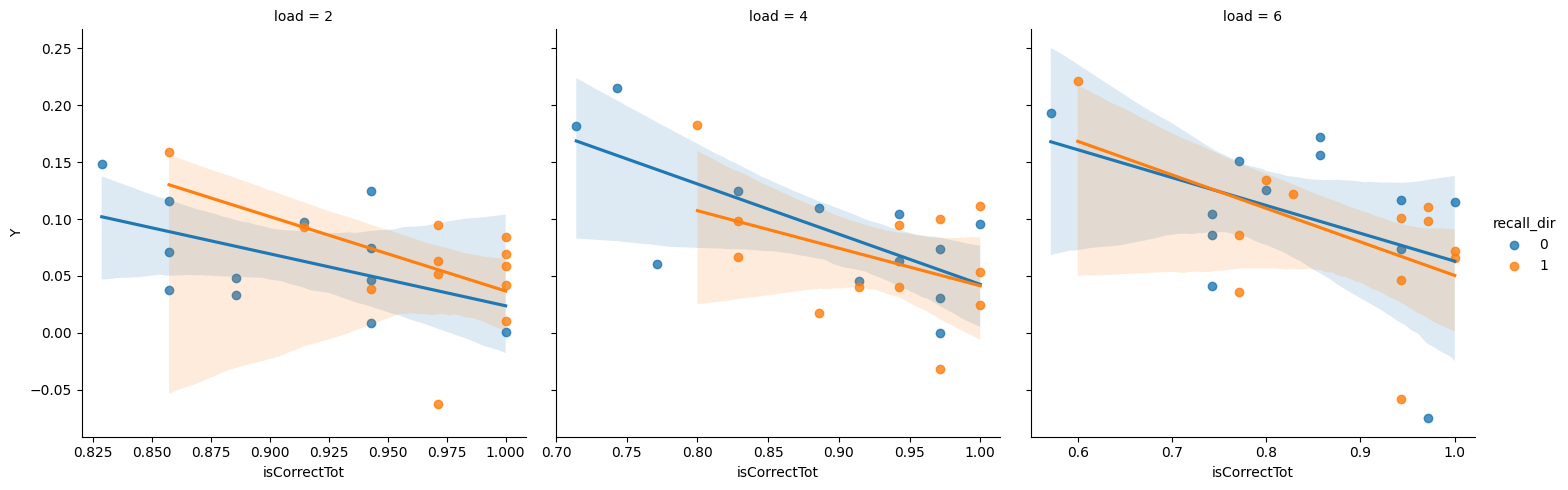

In [40]:
# get the activation for one selected region (within mmultiple demand network)
selected_df = cereb2_df.copy()
roi_name = "DR_P"
df = selected_df.loc[(selected_df.cond_name != "rest") & (selected_df.roi_name == roi_name)]

# prep behavioral dataframe
grouped = D.groupby(["sn", "load", "recall_dir"])
agg_kw = {
          'isCorrectTot':np.mean}
DD = grouped.agg(agg_kw)

# prep activation dataframe
grouped2 = df.groupby(["sn", 'load', 'recall'])
agg_kw = {
          'Y':np.mean,
          }
dff = grouped2.agg(agg_kw)
# make multilevel index into a new column
# dff.set_index(['load', 'recall'], inplace=True)

# Reset the multi-level index and convert it into a new column
dff.reset_index(inplace=True)
DD.reset_index(inplace=True)


dff["recall_dir"] = dff["recall"]

# merge the two dataframes by load and recall
D2 = pd.merge(DD, dff, on = ["sn", "load", "recall_dir"])
D2["isError"] = 1- D2["isCorrectTot"]


# plot
sns.lmplot(data = D2, x = "Y", y = "isCorrectTot", hue = "load", col = "recall_dir", fit_reg = True)
# plot
sns.lmplot(data = D2, y = "Y", x = "isCorrectTot", hue= "recall_dir", col = "load", fit_reg = True, sharex=False)


# sns.scatterplot(
#     data=D2, x="isCorrectTot", y="Y", hue="load", style="recall_dir", palette="tab10"
# )